LSA

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [14]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

df = pd.read_csv('../data/clean_genai-education_2023-2025.csv') 

documents = df['text_clean'].tolist()
texts = [doc.split() for doc in documents]  # tokenized for coherence

In [15]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents)
terms = vectorizer.get_feature_names_out()

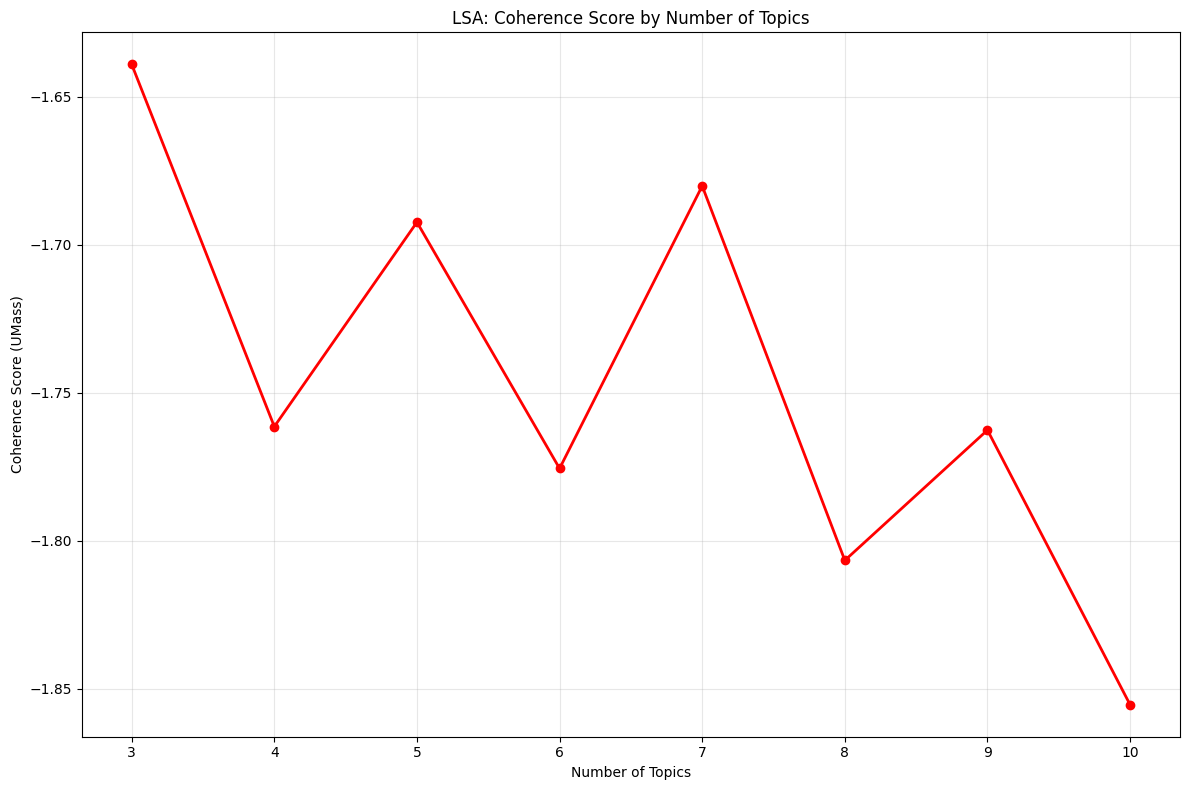


TOPIC SELECTION ANALYSIS:
3 topics: Explained Var = 0.028, Coherence = -1.639
4 topics: Explained Var = 0.036, Coherence = -1.761
5 topics: Explained Var = 0.044, Coherence = -1.692
6 topics: Explained Var = 0.052, Coherence = -1.776
7 topics: Explained Var = 0.060, Coherence = -1.680
8 topics: Explained Var = 0.067, Coherence = -1.807
9 topics: Explained Var = 0.075, Coherence = -1.763
10 topics: Explained Var = 0.082, Coherence = -1.855


In [16]:
# Compute UMass coherence score
from sklearn.metrics.pairwise import cosine_similarity

def compute_coherence_umass(topics, documents):
    coherence_scores = []
    
    for topic_words in topics:
        topic_coherence = 0
        word_pairs = 0
        
        for i in range(len(topic_words)):
            for j in range(i+1, len(topic_words)):
                word1, word2 = topic_words[i], topic_words[j]
                
                # Count co-occurrences
                word1_docs = sum(1 for doc in documents if word1.lower() in doc.lower())
                word2_docs = sum(1 for doc in documents if word2.lower() in doc.lower())
                cooccur_docs = sum(1 for doc in documents if word1.lower() in doc.lower() and word2.lower() in doc.lower())
                
                if word1_docs > 0 and cooccur_docs > 0:
                    score = np.log((cooccur_docs + 1) / word1_docs)
                    topic_coherence += score
                    word_pairs += 1
        
        if word_pairs > 0:
            coherence_scores.append(topic_coherence / word_pairs)
        else:
            coherence_scores.append(0)
    
    return np.mean(coherence_scores)

def compute_lsa_metrics(X, terms, documents, n_topics, num_words=10):
    lsa = TruncatedSVD(n_components=n_topics, random_state=42)
    lsa.fit(X)
    explained_var = lsa.explained_variance_ratio_.sum()
    
    # Extract top words for coherence calculation
    topics = []
    for i, topic in enumerate(lsa.components_):
        top_indices = topic.argsort()[-num_words:][::-1]
        top_words = [terms[idx] for idx in top_indices]
        topics.append(top_words)
    
    # Calculate coherence
    coherence = compute_coherence_umass(topics, documents)
    
    return explained_var, coherence, lsa

# Plot both explained variance and coherence for different numbers of topics
topic_range = range(3, 11)
explained_variances = []
coherence_scores = []

# Compute LSA metrics for different topic numbers
for n in topic_range:
    explained_var, coherence, _ = compute_lsa_metrics(X, terms, documents, n)
    explained_variances.append(explained_var)
    coherence_scores.append(coherence)

# Plot both metrics
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Coherence plot
ax1.plot(topic_range, coherence_scores, marker='o', color='red', linewidth=2)
ax1.set_xlabel("Number of Topics")
ax1.set_ylabel("Coherence Score (UMass)")
ax1.set_title("LSA: Coherence Score by Number of Topics")
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis and recommendation
print("\n" + "="*60)
print("TOPIC SELECTION ANALYSIS:")
print("="*60)
for i, n in enumerate(topic_range):
    print(f"{n} topics: Explained Var = {explained_variances[i]:.3f}, Coherence = {coherence_scores[i]:.3f}")

In [17]:
# Use the recommended number from coherence analysis
n_topics = 4
num_words = 10

# Create final LSA model
lsa_final = TruncatedSVD(n_components=n_topics, random_state=42)
X_lsa = lsa_final.fit_transform(X)

print(f"Topics: {n_topics} (chosen based on coherence analysis)")
print(f"Total Explained Variance: {lsa_final.explained_variance_ratio_.sum():.3f}")
print(f"Document-Topic Matrix Shape: {X_lsa.shape}")
print(f"Vocabulary Size: {len(terms)}")

# Show individual topic variances
print(f"\nIndividual Topic Explained Variances:")
for i, var in enumerate(lsa_final.explained_variance_ratio_):
    print(f"Topic {i+1}: {var:.3f} ({var:.1%})")

Topics: 4 (chosen based on coherence analysis)
Total Explained Variance: 0.036
Document-Topic Matrix Shape: (448, 4)
Vocabulary Size: 1531

Individual Topic Explained Variances:
Topic 1: 0.005 (0.5%)
Topic 2: 0.014 (1.4%)
Topic 3: 0.009 (0.9%)
Topic 4: 0.008 (0.8%)


In [18]:
summary_data = []
for i in range(lsa_final.n_components):
    top_words = [terms[idx] for idx in lsa_final.components_[i].argsort()[-num_words:]][::-1]
    summary_data.append({
        'Topic': f'Topic {i+1}',
        'Explained Variance': f'{lsa_final.explained_variance_ratio_[i]:.1%}',
        'Top 10 Words': ', '.join(top_words),
        'Avg Document Score': f'{X_lsa[:, i].mean():.3f}',
        'Score Std Dev': f'{X_lsa[:, i].std():.3f}'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

  Topic Explained Variance                                                                                       Top 10 Words Avg Document Score Score Std Dev
Topic 1               0.5%                          ai, students, use, education, generative, tools, work, think, used, using              0.182         0.070
Topic 2               1.4%    education, generative, learning, ai, personalized, risks, tools, challenges, educators, support              0.006         0.116
Topic 3               0.9% work, technologies, student, university, unfair, think, generative, technology, learning, academic              0.001         0.092
Topic 4               0.8%           tools, students, use, technology, university, academic, teaching, lead, human, essential             -0.007         0.090


In [19]:
# Compute coherence for a single topic
def compute_single_topic_coherence(topic_words, documents):
    
    topic_coherence = 0
    word_pairs = 0
    
    for i in range(len(topic_words)):
        for j in range(i+1, len(topic_words)):
            word1, word2 = topic_words[i], topic_words[j]
            
            # Count co-occurrences
            word1_docs = sum(1 for doc in documents if word1.lower() in doc.lower())
            word2_docs = sum(1 for doc in documents if word2.lower() in doc.lower())
            cooccur_docs = sum(1 for doc in documents if word1.lower() in doc.lower() and word2.lower() in doc.lower())
            
            if word1_docs > 0 and cooccur_docs > 0:
                score = np.log((cooccur_docs + 1) / word1_docs)
                topic_coherence += score
                word_pairs += 1
    
    return topic_coherence / word_pairs if word_pairs > 0 else 0

# Analyze coherence of individual topics
def analyze_individual_topic_coherence(model, terms, documents, model_name, num_words=10):

    print(f"\nINDIVIDUAL TOPIC COHERENCE ANALYSIS - {model_name}")
    print("="*70)
    
    # Extract topics from the model
    topics = []
    topic_coherences = []
    
    if model_name == "LSA":
        for i in range(model.n_components):
            top_indices = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [terms[idx] for idx in top_indices]
            topics.append(top_words)
            
            # Calculate individual topic coherence
            coherence = compute_single_topic_coherence(top_words, documents)
            topic_coherences.append(coherence)
    
    elif model_name == "LDA":
        for i in range(model.n_components):
            top_indices = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [terms[idx] for idx in top_indices]
            topics.append(top_words)
            
            # Calculate individual topic coherence
            coherence = compute_single_topic_coherence(top_words, documents)
            topic_coherences.append(coherence)
    
    # Create detailed analysis
    coherence_analysis = []
    for i, (topic_words, coherence) in enumerate(zip(topics, topic_coherences)):
        coherence_analysis.append({
            'Topic': f'Topic {i+1}',
            'Coherence': f'{coherence:.4f}',
            'Quality': get_coherence_quality_label(coherence),
            'Top_Words': ', '.join(topic_words[:6])  # Show top 6 words
        })
    
    # Sort by coherence (best to worst)
    coherence_analysis.sort(key=lambda x: float(x['Coherence']), reverse=True)
    
    # Display results
    analysis_df = pd.DataFrame(coherence_analysis)
    print(analysis_df.to_string(index=False))
    
    # Summary statistics
    avg_coherence = np.mean(topic_coherences)
    std_coherence = np.std(topic_coherences)
    best_topic_idx = np.argmax(topic_coherences)
    worst_topic_idx = np.argmin(topic_coherences)
    
    print(f"\nCOHERENCE SUMMARY:")
    print(f"Average Coherence: {avg_coherence:.4f}")
    print(f"Standard Deviation: {std_coherence:.4f}")
    print(f"Best Topic: Topic {best_topic_idx + 1} ({topic_coherences[best_topic_idx]:.4f})")
    print(f"Worst Topic: Topic {worst_topic_idx + 1} ({topic_coherences[worst_topic_idx]:.4f})")
    
    # Quality assessment
    high_quality_topics = sum(1 for c in topic_coherences if c > -1.5)
    medium_quality_topics = sum(1 for c in topic_coherences if -2.0 <= c <= -1.5)
    low_quality_topics = sum(1 for c in topic_coherences if c < -2.0)
    
    print(f"\nQUALITY DISTRIBUTION:")
    print(f"High Quality Topics (>-1.5): {high_quality_topics}")
    print(f"Medium Quality Topics (-2.0 to -1.5): {medium_quality_topics}")
    print(f"Low Quality Topics (<-2.0): {low_quality_topics}")
    
    return topic_coherences, topics

# UMass coherence: higher (closer to 0) is better
def get_coherence_quality_label(coherence):
    if coherence > -1.5:
        return "High"
    elif coherence > -2.0:
        return "Medium"
    else:
        return "Low"

# Analyze LSA individual topic coherence
lsa_topic_coherences, lsa_topics = analyze_individual_topic_coherence(
    lsa_final, terms, documents, "LSA", num_words=10
)


INDIVIDUAL TOPIC COHERENCE ANALYSIS - LSA
  Topic Coherence Quality                                                Top_Words
Topic 1   -1.4218    High          ai, students, use, education, generative, tools
Topic 3   -1.6725  Medium   work, technologies, student, university, unfair, think
Topic 2   -1.9117  Medium education, generative, learning, ai, personalized, risks
Topic 4   -2.0396     Low   tools, students, use, technology, university, academic

COHERENCE SUMMARY:
Average Coherence: -1.7614
Standard Deviation: 0.2362
Best Topic: Topic 1 (-1.4218)
Worst Topic: Topic 4 (-2.0396)

QUALITY DISTRIBUTION:
High Quality Topics (>-1.5): 1
Medium Quality Topics (-2.0 to -1.5): 2
Low Quality Topics (<-2.0): 1


LDA

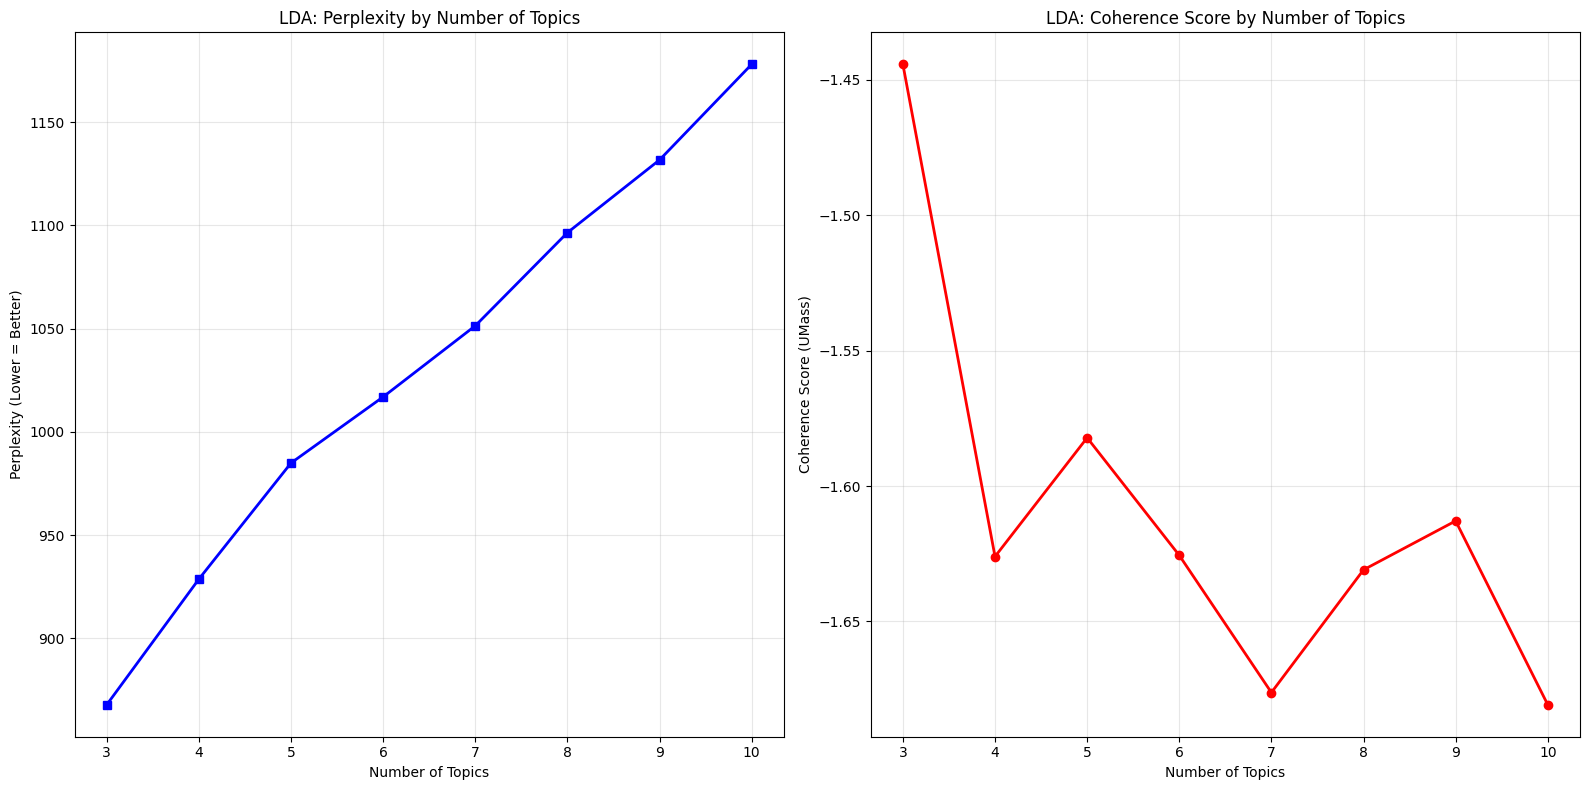

3 topics: Perplexity = 867.92, Coherence = -1.444
4 topics: Perplexity = 928.75, Coherence = -1.626
5 topics: Perplexity = 984.97, Coherence = -1.582
6 topics: Perplexity = 1016.98, Coherence = -1.626
7 topics: Perplexity = 1051.41, Coherence = -1.676
8 topics: Perplexity = 1096.50, Coherence = -1.631
9 topics: Perplexity = 1131.73, Coherence = -1.613
10 topics: Perplexity = 1178.02, Coherence = -1.681


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Load dataset
df = pd.read_csv('../data/clean_genai-education_2023-2025.csv')
documents = df['text_clean'].dropna().tolist()

vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_lda_vectorized = vectorizer_lda.fit_transform(documents)
terms_lda = vectorizer_lda.get_feature_names_out()

# Use the same coherence function as LSA
def compute_lda_metrics(X, terms, documents, n_topics, num_words=10):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    
    # Calculate perplexity
    perplexity = lda.perplexity(X)
    
    # Extract top words for coherence calculation
    topics = []
    for i, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[-num_words:][::-1]
        top_words = [terms[idx] for idx in top_indices]
        topics.append(top_words)
    
    # Calculate coherence using the same function as LSA
    coherence = compute_coherence_umass(topics, documents)
    
    return perplexity, coherence, lda

# Evaluate different numbers of topics for LDA
topic_range = range(3, 11)
perplexity_scores = []
coherence_scores_lda = []

for n in topic_range:
    perplexity, coherence, _ = compute_lda_metrics(X_lda_vectorized, terms_lda, documents, n)
    perplexity_scores.append(perplexity)
    coherence_scores_lda.append(coherence)

# Plot all three metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Perplexity plot (lower is better)
ax1.plot(topic_range, perplexity_scores, marker='s', color='blue', linewidth=2)
ax1.set_xlabel("Number of Topics")
ax1.set_ylabel("Perplexity (Lower = Better)")
ax1.set_title("LDA: Perplexity by Number of Topics")
ax1.grid(alpha=0.3)

# Coherence plot (higher is better, closer to 0 for UMass)
ax2.plot(topic_range, coherence_scores_lda, marker='o', color='red', linewidth=2)
ax2.set_xlabel("Number of Topics")
ax2.set_ylabel("Coherence Score (UMass)")
ax2.set_title("LDA: Coherence Score by Number of Topics")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize and analyze results
for i, n in enumerate(topic_range):
    print(f"{n} topics: Perplexity = {perplexity_scores[i]:.2f}, Coherence = {coherence_scores_lda[i]:.3f}")


# Best perplexity (lowest)
best_perplexity_idx = perplexity_scores.index(min(perplexity_scores))
best_perplexity_topics = topic_range[best_perplexity_idx]

# Best coherence (highest for UMass)
best_coherence_idx = coherence_scores_lda.index(max(coherence_scores_lda))
best_coherence_topics = topic_range[best_coherence_idx]

In [21]:
n_topics_lda = 3
num_words = 10

print(f"Selected: {n_topics_lda} topics (based on comprehensive analysis)")

# Create final LDA model
lda_final = LatentDirichletAllocation(n_components=n_topics_lda, random_state=42)
X_lda_final = lda_final.fit_transform(X_lda_vectorized)

print(f"\nLDA Model Created Successfully!\n")
print(f"Topics: {n_topics_lda}")
print(f"Perplexity: {lda_final.perplexity(X_lda_vectorized):.2f}")
print(f"Document-Topic Matrix Shape: {X_lda_final.shape}")
print(f"Vocabulary Size: {len(terms_lda)}")

Selected: 3 topics (based on comprehensive analysis)

LDA Model Created Successfully!

Topics: 3
Perplexity: 867.92
Document-Topic Matrix Shape: (448, 3)
Vocabulary Size: 1531


In [22]:
# Calculate topic proportions for LDA
topic_proportions_lda = X_lda_final.mean(axis=0)

# Analyze LDA individual topic coherence
lda_topic_coherences, lda_topics = analyze_individual_topic_coherence(
    lda_final, terms_lda, documents, "LDA", num_words=10
)


INDIVIDUAL TOPIC COHERENCE ANALYSIS - LDA
  Topic Coherence Quality                                          Top_Words
Topic 3   -1.4126    High               ai, students, use, think, work, used
Topic 2   -1.4236    High ai, generative, education, students, learning, use
Topic 1   -1.4965    High               ai, use, students, using, like, work

COHERENCE SUMMARY:
Average Coherence: -1.4442
Standard Deviation: 0.0372
Best Topic: Topic 3 (-1.4126)
Worst Topic: Topic 1 (-1.4965)

QUALITY DISTRIBUTION:
High Quality Topics (>-1.5): 3
Medium Quality Topics (-2.0 to -1.5): 0
Low Quality Topics (<-2.0): 0


In [23]:
summary_data_lda = []
for i in range(lda_final.n_components):
    top_words = [terms_lda[idx] for idx in lda_final.components_[i].argsort()[-num_words:]][::-1]
    summary_data_lda.append({
        'Topic': f'Topic {i+1}',
        'Proportion': f'{topic_proportions_lda[i]:.1%}',
        'Top 10 Words': ', '.join(top_words),
        'Avg Doc Probability': f'{X_lda_final[:, i].mean():.3f}',
        'Std Dev': f'{X_lda_final[:, i].std():.3f}'
    })

summary_df_lda = pd.DataFrame(summary_data_lda)
print("\nLDA TOPIC SUMMARY:")
print("="*170)
print(summary_df_lda.to_string(index=False))



LDA TOPIC SUMMARY:
  Topic Proportion                                                                        Top 10 Words Avg Doc Probability Std Dev
Topic 1      29.2%                   ai, use, students, using, like, work, think, just, chatgpt, tools               0.292   0.370
Topic 2      35.5% ai, generative, education, students, learning, use, student, tools, educators, used               0.355   0.384
Topic 3      35.3%           ai, students, use, think, work, used, university, learning, student, just               0.353   0.393



COMPARATIVE TOPIC COHERENCE VISUALIZATION

COMPARATIVE ANALYSIS:
----------------------------------------
LSA Average Coherence: -1.7614
LDA Average Coherence: -1.4442
LDA has higher average topic coherence

QUALITY COMPARISON:
Model      High     Medium   Low     
-----------------------------------
LSA        1        2        1       
LDA        3        0        0       


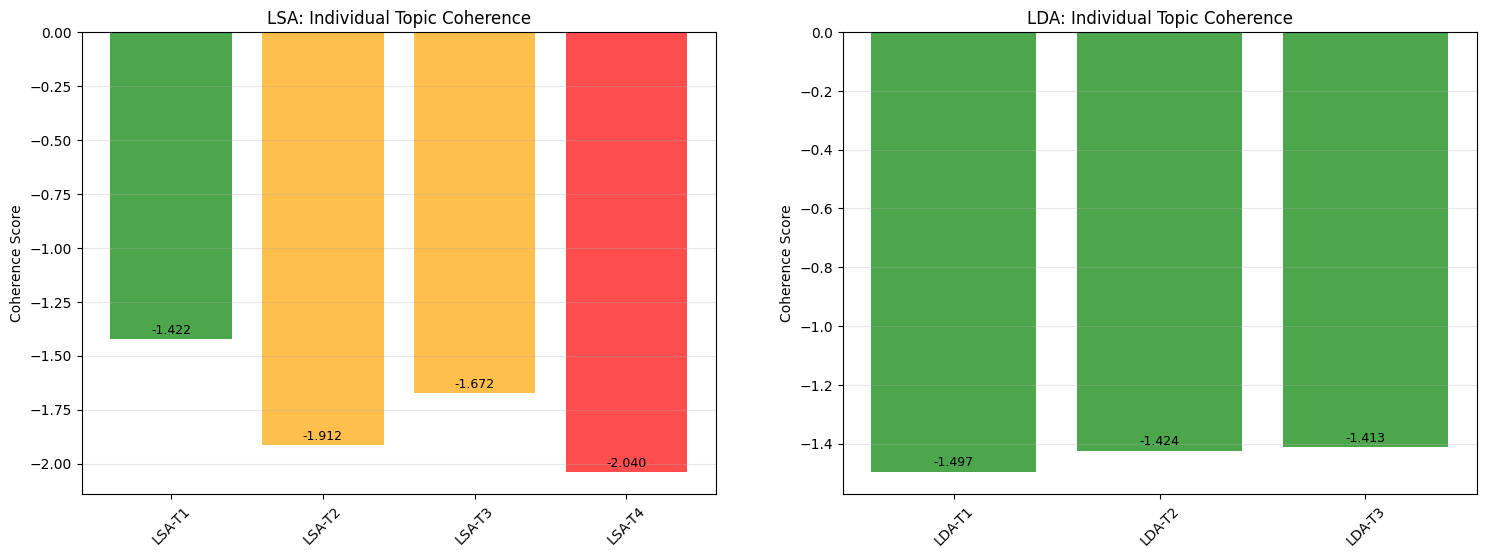

In [ ]:
# visualizations comparing individual topic coherences between models
def create_topic_coherence_comparison(lsa_coherences, lda_coherences, lsa_topics, lda_topics):

    print(f"\nCOMPARATIVE TOPIC COHERENCE VISUALIZATION")
    print("="*60)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: LSA Topic Coherences
    lsa_topic_names = [f'LSA-T{i+1}' for i in range(len(lsa_coherences))]
    colors_lsa = ['green' if c > -1.5 else 'orange' if c > -2.0 else 'red' for c in lsa_coherences]
    
    bars1 = ax1.bar(lsa_topic_names, lsa_coherences, color=colors_lsa, alpha=0.7)
    ax1.set_title('LSA: Individual Topic Coherence')
    ax1.set_ylabel('Coherence Score')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, coherence in zip(bars1, lsa_coherences):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{coherence:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: LDA Topic Coherences
    lda_topic_names = [f'LDA-T{i+1}' for i in range(len(lda_coherences))]
    colors_lda = ['green' if c > -1.5 else 'orange' if c > -2.0 else 'red' for c in lda_coherences]
    
    bars2 = ax2.bar(lda_topic_names, lda_coherences, color=colors_lda, alpha=0.7)
    ax2.set_title('LDA: Individual Topic Coherence')
    ax2.set_ylabel('Coherence Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, coherence in zip(bars2, lda_coherences):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{coherence:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Comparative analysis
    print(f"\nCOMPARATIVE ANALYSIS:")
    print("-" * 40)
    print(f"LSA Average Coherence: {np.mean(lsa_coherences):.4f}")
    print(f"LDA Average Coherence: {np.mean(lda_coherences):.4f}")
    
    if np.mean(lsa_coherences) > np.mean(lda_coherences):
        print("LSA has higher average topic coherence")
    else:
        print("LDA has higher average topic coherence")
    
    # Quality distribution comparison
    def count_quality_topics(coherences):
        high = sum(1 for c in coherences if c > -1.5)
        medium = sum(1 for c in coherences if -2.0 <= c <= -1.5)
        low = sum(1 for c in coherences if c < -2.0)
        return high, medium, low
    
    lsa_high, lsa_med, lsa_low = count_quality_topics(lsa_coherences)
    lda_high, lda_med, lda_low = count_quality_topics(lda_coherences)
    
    print(f"{'Model':<10} {'High':<8} {'Medium':<8} {'Low':<8}")
    print("-" * 35)
    print(f"{'LSA':<10} {lsa_high:<8} {lsa_med:<8} {lsa_low:<8}")
    print(f"{'LDA':<10} {lda_high:<8} {lda_med:<8} {lda_low:<8}")

# Create the comparative visualization
create_topic_coherence_comparison(lsa_topic_coherences, lda_topic_coherences, lsa_topics, lda_topics)